In [1]:
import sys
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting data
import os
#import re
np.random.seed(42)

In [25]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


In [17]:
folder_path = r'../data/'
dfs = {}
for filename in os.listdir(folder_path):
    #print(filename)
    if filename.startswith('Descriptors') and filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)

        pfas_name = filename.removeprefix('Descriptors-').removesuffix('.csv')
        # pfas_name = filename.replace('Descriptors-', '')
        # pfas_name = pfas_name.replace('.csv', '')
        print(pfas_name)
        dfs[pfas_name] = df

PFOA
PFOS


In [23]:
dfs['PFOS']

,Serial,Name,Density,PLD,LCD,GSA,Void_Fraction,Pore_Volume
0,1,UiO-66,1.23478,3.82175,8.70307,2920.55,0.590055,0.477861
1,2,UiO-66-NH2,2.02273,1.27596,7.33306,2383.43,0.416850,0.206083
2,3,UiO-66-F4,1.64040,1.08214,2.71819,4812.39,0.281035,0.171321
3,4,UiO-67,0.72259,6.73387,12.96894,3474.86,0.739285,1.023110
4,5,MOF-801,1.59198,3.43715,7.65165,2470.35,0.550820,0.345996
5,6,PCN-222,0.48683,30.98849,32.02394,3517.78,0.823395,1.691350
6,7,PCN-224,0.50916,14.43274,24.14176,3321.71,0.823815,1.618000
7,8,NU-1000,0.48604,28.47867,29.11714,3504.23,0.820910,1.688980
8,9,MIL-53(Al)-as,1.00403,5.97083,6.57739,3879.52,0.597735,0.595335
9,10,DUT-4,1.47169,2.58681,2.78656,4299.53,0.361415,0.245579


In [ ]:
ls

In [27]:
# Core descriptor set
FEATURES = [
    "PLD",
    "LCD",
    "GSA",
    "Void_Fraction",
    "Pore_Volume",
    # "Density",  # uncomment later for sensitivity analysis
]

# Select PFAS dataset
df = dfs["PFOS"].copy()

# Extract feature matrix
X = df[FEATURES].values


In [35]:
X[2]

array([1.08214e+00, 2.71819e+00, 4.81239e+03, 2.81035e-01, 1.71321e-01])

In [136]:
ocsvm = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("ocsvm", OneClassSVM(
            kernel="rbf",
            nu=0.15,      # ~nu% of points allowed outside boundary
            gamma="scale" # reasonable default; refine later
        ))
    ]
)


In [128]:
ocsvm.named_steps["ocsvm"].nu

float

In [138]:
ocsvm.fit(X)


Pipeline(steps=[('scaler', StandardScaler()), ('ocsvm', OneClassSVM(nu=0.15))])

In [140]:
# Decision function: higher = more confidently inside the region
scores = ocsvm.decision_function(X)

# Binary labels: +1 = inlier, -1 = outlier
labels = ocsvm.predict(X)

df_results = df.copy()
df_results["ocsvm_score"] = scores
df_results["ocsvm_label"] = labels


In [142]:
df_results.sort_values("ocsvm_score")


,Serial,Name,Density,PLD,LCD,GSA,Void_Fraction,Pore_Volume,ocsvm_score,ocsvm_label
1,2,UiO-66-NH2,2.02273,1.27596,7.33306,2383.43,0.416850,0.206083,-0.000242,-1
4,5,MOF-801,1.59198,3.43715,7.65165,2470.35,0.550820,0.345996,-0.000242,-1
11,12,ZIF-8,0.91650,3.53498,11.98309,4879.00,0.641990,0.700482,-0.000212,-1
2,3,UiO-66-F4,1.64040,1.08214,2.71819,4812.39,0.281035,0.171321,-0.000192,-1
10,11,DUT-5,0.65191,11.24448,11.45407,4516.55,0.706970,1.084460,-0.000095,-1
3,4,UiO-67,0.72259,6.73387,12.96894,3474.86,0.739285,1.023110,0.000118,1
6,7,PCN-224,0.50916,14.43274,24.14176,3321.71,0.823815,1.618000,0.000146,1
5,6,PCN-222,0.48683,30.98849,32.02394,3517.78,0.823395,1.691350,0.000720,1
7,8,NU-1000,0.48604,28.47867,29.11714,3504.23,0.820910,1.688980,0.033334,1
0,1,UiO-66,1.23478,3.82175,8.70307,2920.55,0.590055,0.477861,0.033683,1


In [45]:
FEATURES_WITH_DENSITY = FEATURES + ["Density"]
X_density = df[FEATURES_WITH_DENSITY].values

ocsvm_density = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("ocsvm", OneClassSVM(
            kernel="rbf",
            nu=0.15,
            gamma="scale"
        ))
    ]
)

ocsvm_density.fit(X_density)

df_results2["ocsvm_score_with_density"] = ocsvm_density.decision_function(X_density)


In [47]:
df_results[[
    "Name",
    "ocsvm_score",
    "ocsvm_label"
]]

,Name,ocsvm_score,ocsvm_label
0,UiO-66,0.033683,1
1,UiO-66-NH2,-0.000242,-1
2,UiO-66-F4,-0.000192,-1
3,UiO-67,0.000118,1
4,MOF-801,-0.000242,-1
5,PCN-222,0.000720,1
6,PCN-224,0.000146,1
7,NU-1000,0.033334,1
8,MIL-53(Al)-as,0.073577,1
9,DUT-4,0.067434,1


# Plotting
- Plot the exact OC-SVM boundary is *impossible* because it lives in 5-6 dimensional (features) space further increased by the kernel induced space.

So the objective becomes to "Visualize how points relate to the OC-SVM decision function in a meaningful 2D projection":

- 


In [144]:
scaler = ocsvm.named_steps["scaler"]
svm = ocsvm.named_steps["ocsvm"]
nu = ocsvm.named_steps["ocsvm"].nu
X_scaled = scaler.transform(X)


In [166]:
X_scale

array([[-0.54074739, -0.47571596, -1.00365712, -0.13503409, -0.6129289 ],
       [-0.80642734, -0.62598584, -1.66193907, -1.15599218, -1.11463687],
       [-0.8266545 , -1.13216898,  1.31493861, -1.95655466, -1.17880826],
       [-0.23683704, -0.00781296, -0.32430749,  0.7446032 ,  0.39361235],
       [-0.58088444, -0.59104122, -1.55541191, -0.36630507, -0.8563545 ],
       [ 2.29438762,  2.08223936, -0.27170572,  1.24039019,  1.6271976 ],
       [ 0.56662101,  1.21768053, -0.51200462,  1.24286588,  1.49179194],
       [ 2.03246151,  1.7634063 , -0.28831229,  1.22574234,  1.62282253],
       [-0.31646829, -0.70887169,  0.17163453, -0.08976427, -0.3960694 ],
       [-0.66962636, -1.1246698 ,  0.68638915, -1.48275418, -1.04172642],
       [ 0.23389255, -0.17397185,  0.95236389,  0.5541222 ,  0.50686575],
       [-0.57067485, -0.11594616,  1.3965743 ,  0.17109714, -0.2019658 ],
       [-0.57904248, -0.10714173,  1.09543775,  0.00758351, -0.23980001]])

In [148]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance:", pca.explained_variance_ratio_)


Explained variance: [0.73454321 0.19853982]


In [150]:
#Build a grid in PCA space

x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_pca = np.c_[xx.ravel(), yy.ravel()]


In [152]:
# Back to scaled feature space
grid_scaled = pca.inverse_transform(grid_pca)

# Evaluate OC-SVM decision function
Z = svm.decision_function(grid_scaled)
Z = Z.reshape(xx.shape)


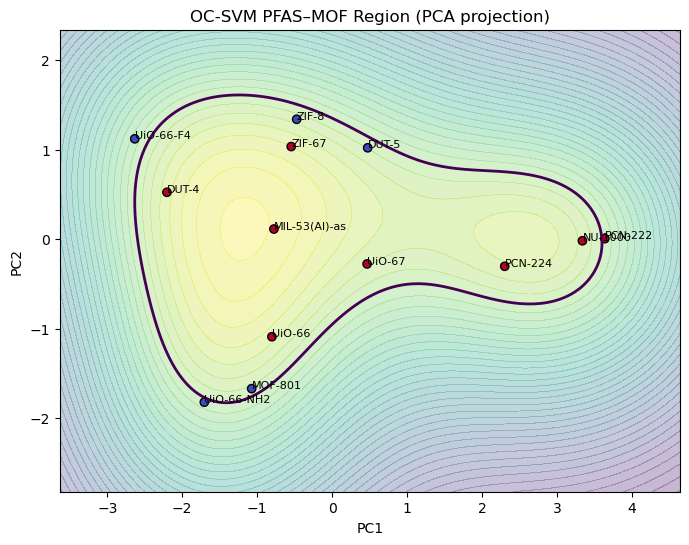

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Decision boundary (score = 0)
plt.contour(xx, yy, Z, levels=[0], linewidths=2)

# Filled contours (optional)
plt.contourf(xx, yy, Z, levels=50, alpha=0.3)

# Plot points
labels = ocsvm.predict(X)
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=labels, cmap="coolwarm", edgecolors="k"
)

# Annotate MOFs
for i, name in enumerate(df["Name"]):
    plt.text(X_pca[i, 0], X_pca[i, 1], name, fontsize=8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("OC-SVM PFAS–MOF Region (PCA projection)")
#plt.savefig("PCA-Region.png")
plt.savefig(rf"..\Notebooks\OCSVM-Region-nu{nu}.png", 
            format='png', 
            bbox_inches='tight', 
            transparent=True,
            pad_inches=0)
plt.show()
